# Project: Sentiment Analysis on Tweets About Tesla Using FinBERT

This project performs sentiment analysis on tweets related to Tesla using FinBERT, a pre-trained language model specifically tuned for financial texts. Given the market influence of Tesla and its CEO's frequent and impactful presence on social media, analyzing public sentiment toward Tesla can offer valuable insights. The FinBERT model is applied to classify each tweet as positive, negative, or neutral from a financial perspective. This notebook covers data collection, text preprocessing, sentiment classification, and visualization of sentiment trends.

The datasets can be downloaded from Kaggle: 
https://www.kaggle.com/datasets/omermetinn/tweets-about-the-top-companies-from-2015-to-2020

In [1]:
#pip install kagglehub
#pip install transformers
#pip install finbert-embedding
#pip install huggingface_hub[hf_xet]

In [2]:
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import huggingface_hub
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Data overview

In [3]:
# Download latest version
# path = kagglehub.dataset_download("omermetinn/tweets-about-the-top-companies-from-2015-to-2020")
# print("Path to dataset files:", path)

In [4]:
df1 = pd.read_csv('Company.csv')
df2 = pd.read_csv('Company_Tweet.csv')
df3 = pd.read_csv('Tweet.csv')

In [5]:
df1.head(3)

,ticker_symbol,company_name
0,AAPL,apple
1,GOOG,Google Inc
2,GOOGL,Google Inc


In [6]:
df2.head(3)

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL
2,550803225113157632,AAPL


In [7]:
df3.head(3)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0


# Fetching the tweet commentary for Tesla

In [8]:
df2_Tesla = df2.loc[df2['ticker_symbol'] == "TSLA"]
print(df2_Tesla['ticker_symbol'].value_counts())

ticker_symbol
TSLA    1096868
Name: count, dtype: int64


In [9]:
df2_Tesla.shape

(1096868, 2)

In [10]:
df2_Tesla.head(3)

,tweet_id,ticker_symbol
3239577,550442977802207232,TSLA
3239578,550443807834402816,TSLA
3239579,550443808606126081,TSLA


In [11]:
tesla_tweet = pd.merge(df2_Tesla, df3, on='tweet_id')

In [12]:
tesla_tweet.head(3)

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
0,550442977802207232,TSLA,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
1,550443807834402816,TSLA,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
2,550443808606126081,TSLA,aaplstocknews,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


In [13]:
tesla_tweet['post_date'] = pd.to_datetime(tesla_tweet['post_date'],unit='s').dt.strftime('%Y-%m-%d')

# Basic Information about Tesla's Tweet Commentary

In [14]:
tesla_tweet

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
0,550442977802207232,TSLA,ShowDreamCar,2015-01-01,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
1,550443807834402816,TSLA,i_Know_First,2015-01-01,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
2,550443808606126081,TSLA,aaplstocknews,2015-01-01,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
3,550443809700851716,TSLA,iknowfirst,2015-01-01,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
4,550443857142611968,TSLA,Cprediction,2015-01-01,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
...,...,...,...,...,...,...,...,...
1096863,1212158772015034369,TSLA,StockJoke,2019-12-31,"I'm getting wasted on NYE, and thanks to @NHTS...",0,0,0
1096864,1212159099632267268,TSLA,sweetog76,2019-12-31,$TSLA Very Interesting dude:,0,0,0
1096865,1212159184931717120,TSLA,MelaynaLokosky,2019-12-31,If only 2020 brought more self-awareness to Te...,0,1,0
1096866,1212159838882533376,TSLA,ShortingIsFun,2019-12-31,In 2020 I may start Tweeting out positive news...,0,0,1


In [15]:
tweet_count = pd.DataFrame(tesla_tweet['post_date'].value_counts())
tweet_count = tweet_count.reset_index()
tweet_count.columns = ['Date', 'Amount']

In [16]:
tweet_count.head(3)

,Date,Amount
0,2018-08-07,6408
1,2018-08-08,4624
2,2018-09-28,4443


In [17]:
# Basic statistics of tweet amounts
tweet_count.describe()

,Amount
count,1826.000000
mean,600.694414
std,581.011815
min,19.000000
25%,237.000000
50%,406.000000
75%,779.000000
max,6408.000000


In [18]:
tweet_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1826 non-null   object
 1   Amount  1826 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 28.7+ KB


# Load the pre-trained FinBERT model

In [19]:
finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# Create a sentiment analysis pipeline using FinBERT
finbert_sentiment = pipeline("sentiment-analysis", model=finbert_model, tokenizer=finbert_tokenizer)

Device set to use cpu


# Sampling the first 100 tweets for analysis

In [20]:
# Sample: only analyze the first 100 tweets to avoid slow processing
sample_100 = tesla_tweet['body'].dropna().head(100)

# Perform sentiment analysis using FinBERT
results = finbert_sentiment(sample_100.tolist())

# Add the sentiment results back to a new DataFrame
sample_100_result = sample_100.reset_index(drop=True).to_frame()
sample_100_result['sentiment'] = [r['label'] for r in results]
sample_100_result['score'] = [r['score'] for r in results]

In [21]:
sample_100_result.head()

,body,sentiment,score
0,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,positive,0.845187
1,Swing Trading: Up To 8.91% Return In 14 Days h...,positive,0.779838
2,Swing Trading: Up To 8.91% Return In 14 Days h...,positive,0.795317
3,Swing Trading: Up To 8.91% Return In 14 Days h...,positive,0.783499
4,Swing Trading: Up To 8.91% Return In 14 Days h...,positive,0.798992


sentiment
neutral     85
positive    12
negative     3
Name: count, dtype: int64


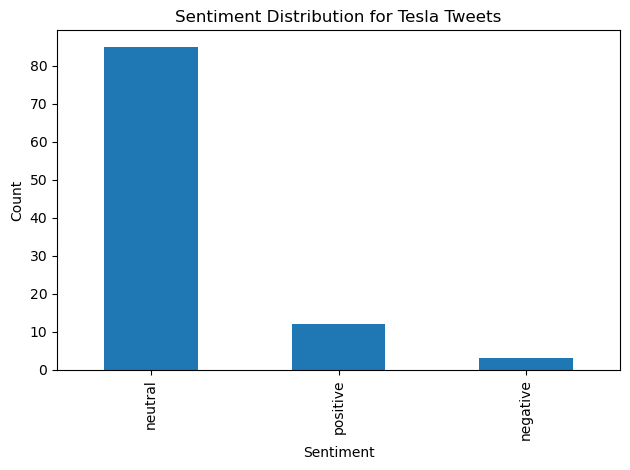

In [22]:
# Count the number of each sentiment category
sentiment_counts_100 = sample_100_result['sentiment'].value_counts()

# Print the sentiment counts
print(sentiment_counts_100)

# Plot a bar chart of sentiment distribution
sentiment_counts_100.plot(kind='bar', title='Sentiment Distribution for Tesla Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

The vast majority of the sampled Tesla tweets are neutral, 
with only a small portion being positive or negative. 
This is common in financial texts, especially when tweets contain factual or ambiguous language.

# Sampling the first 1000 tweets for analysis

In [23]:
# Sample: only analyze the first 1000 tweets with body and post_date
sample_1000 = tesla_tweet[['body', 'post_date']].dropna(subset=['body', 'post_date']).head(1000)

# Perform sentiment analysis using FinBERT
results = finbert_sentiment(sample_1000['body'].tolist())

# Add the sentiment results back to a new DataFrame
sample_1000_result = sample_1000.reset_index(drop=True).copy()
sample_1000_result['sentiment'] = [r['label'] for r in results]
sample_1000_result['score'] = [r['score'] for r in results]

In [24]:
sample_1000_result

,body,post_date,sentiment,score
0,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,2015-01-01,positive,0.845187
1,Swing Trading: Up To 8.91% Return In 14 Days h...,2015-01-01,positive,0.779838
2,Swing Trading: Up To 8.91% Return In 14 Days h...,2015-01-01,positive,0.795317
3,Swing Trading: Up To 8.91% Return In 14 Days h...,2015-01-01,positive,0.783499
4,Swing Trading: Up To 8.91% Return In 14 Days h...,2015-01-01,positive,0.798992
...,...,...,...,...
995,$TSLA filled $205-$206 gap this morning and is...,2015-01-06,positive,0.928960
996,nice short covering rally on my $TSLA. I am tr...,2015-01-06,positive,0.574513
997,Automakers are stealing the buzz from gadgets ...,2015-01-06,neutral,0.882964
998,$TSLA held the key support again & trying for ...,2015-01-06,neutral,0.613263


sentiment
neutral     824
positive     89
negative     87
Name: count, dtype: int64


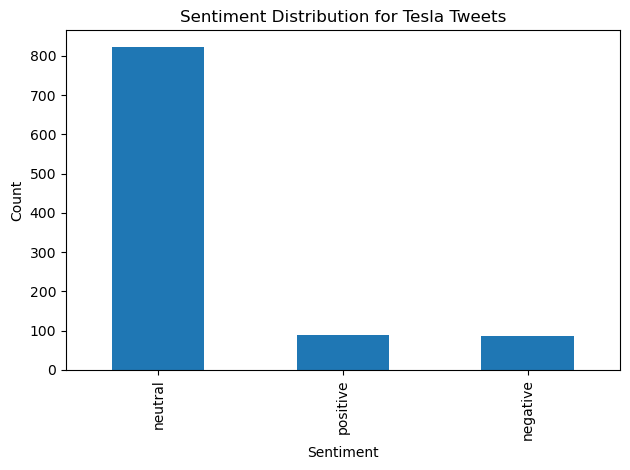

In [25]:
# Count the number of each sentiment category
sentiment_counts_1000 = sample_1000_result['sentiment'].value_counts()

# Print the sentiment counts
print(sentiment_counts_1000)

# Plot a bar chart of sentiment distribution
sentiment_counts_1000.plot(kind='bar', title='Sentiment Distribution for Tesla Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

The sentiment is still predominantly neutral, 
but the proportion of positive and negative tweets has increased compared to the smaller sample.
This suggests that public sentiment towards Tesla on Twitter has more variation when considering a larger dataset.

# Visualizing the Daily Sentiment Trend

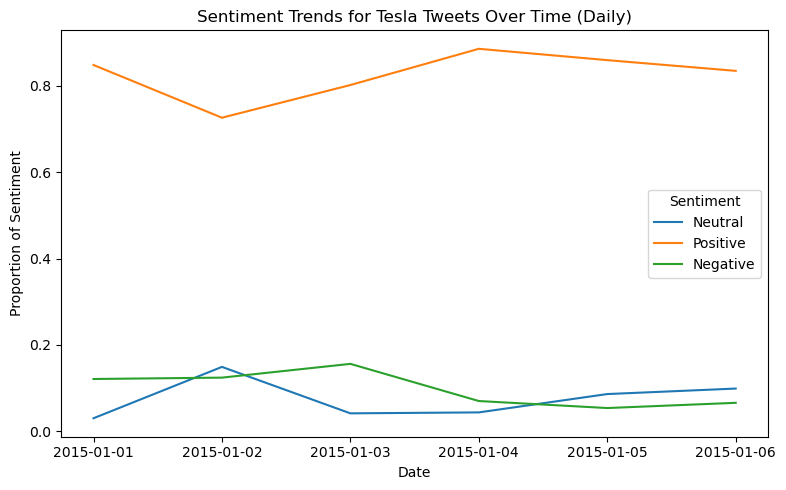

In [26]:
# Group by 'date' and calculate sentiment proportions
sentiment_by_date = sample_1000_result.groupby('post_date')['sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Plot sentiment over time by date
sentiment_by_date.plot(kind='line', figsize=(8, 5), title='Sentiment Trends for Tesla Tweets Over Time (Daily)')
plt.xlabel('Date')
plt.ylabel('Proportion of Sentiment')
plt.legend(title='Sentiment', labels=['Neutral', 'Positive', 'Negative'])
plt.tight_layout()
plt.show()